In [ ]:
!pip install chart_studio

In [ ]:
!pip install plotly

In [ ]:
!pip install cufflinks

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected = True)

from wordcloud import WordCloud

from sklearn import linear_model
lin_reg = linear_model.LinearRegression()

from sklearn.preprocessing import LabelEncoder

In [ ]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Colab Notebooks/covid/input/coronavirusdataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/Colab Notebooks/covid/input/coronavirusdataset/Case.csv
/content/drive/MyDrive/Colab Notebooks/covid/input/coronavirusdataset/Region.csv
/content/drive/MyDrive/Colab Notebooks/covid/input/coronavirusdataset/PatientInfo.csv
/content/drive/MyDrive/Colab Notebooks/covid/input/coronavirusdataset/Policy.csv
/content/drive/MyDrive/Colab Notebooks/covid/input/coronavirusdataset/SearchTrend.csv
/content/drive/MyDrive/Colab Notebooks/covid/input/coronavirusdataset/SeoulFloating.csv
/content/drive/MyDrive/Colab Notebooks/covid/input/coronavirusdataset/Time.csv
/content/drive/MyDrive/Colab Notebooks/covid/input/coronavirusdataset/TimeGender.csv
/content/drive/MyDrive/Colab Notebooks/covid/input/coronavirusdataset/Weather.csv
/content/drive/MyDrive/Colab Notebooks/covid/input/coronavirusdataset/TimeAge.csv
/content/drive/MyDrive/Colab Notebooks/covid/input/coronavirusdataset/TimeProvince.csv


Load and check data

1. TimeAge - time series data on the patients by age
2. TimeProvince - time series data by administrative region
3. Region - metadata on each region
4. TimeGender - time series data on the patients by sex
5. Time - time series data on the tests and the results
6. Case - data on infection cases (path of transmission)
7. Weather - time series data on the weather in each region
8. PatientInfo - sparse data on the profiles of some confirmed patients
9. SeoulFloating - time series data on the floating population in Seoul
10. SearchTrend - time series data on the search keywords related to COVID-19 and other respiratory diseases
11. Policy - sparse data on the policies implemented by S.Korean government on COVID-19
-. PatientRoute - saprse data on the patients' activities before being confirmed
    # Discarded from the original dataset as of 2020-06-30


In [ ]:
timeage = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/covid/input/coronavirusdataset/TimeAge.csv")
region = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/covid/input/coronavirusdataset/Region.csv")
time = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/covid/input/coronavirusdataset/Time.csv")
weather = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/covid/input/coronavirusdataset/Weather.csv")
searchtrend = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/covid/input/coronavirusdataset/SearchTrend.csv")
timeprovince = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/covid/input/coronavirusdataset/TimeProvince.csv")
timegender = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/covid/input/coronavirusdataset/TimeGender.csv")
patientinfo = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/covid/input/coronavirusdataset/PatientInfo.csv")

#patientroute = pd.read_csv("/kaggle/input/coronavirusdataset/PatientRoute.csv")
case = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/covid/input/coronavirusdataset/Case.csv")

## Deceased People and Age Distribution
- timeage data를 이용하여 연령별 deceased(사망자) 분석

In [ ]:
timeage.head()

,date,time,age,confirmed,deceased
0,2020-03-02,0,0s,32,0
1,2020-03-02,0,10s,169,0
2,2020-03-02,0,20s,1235,0
3,2020-03-02,0,30s,506,1
4,2020-03-02,0,40s,633,1


In [ ]:
timeage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089 entries, 0 to 1088
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       1089 non-null   object
 1   time       1089 non-null   int64 
 2   age        1089 non-null   object
 3   confirmed  1089 non-null   int64 
 4   deceased   1089 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 42.7+ KB


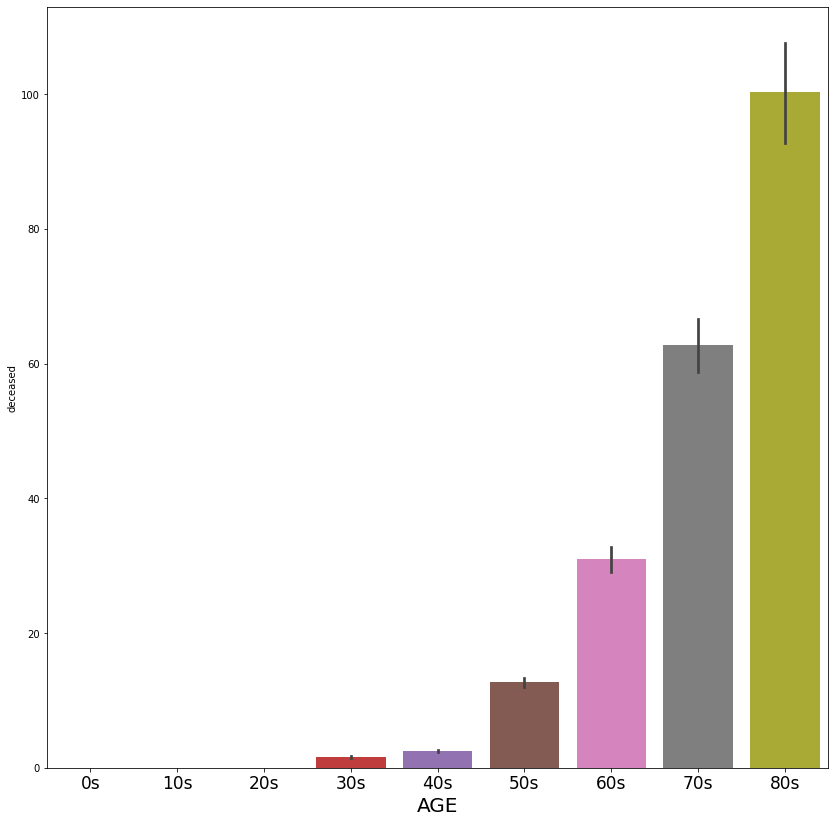

In [ ]:
f,ax = plt.subplots(figsize = (14,14))
ax = sns.barplot(x="age",y="deceased",data=timeage)
plt.xlabel("AGE",fontsize = 20)
plt.xticks(fontsize = 17)
plt.show()

- 50s 부터 사망자수가 늘고 있음을 볼 수 있다.
- 40s 부터 증가폭이 커지고 있다.

In [ ]:
#The age's in the timeage dataframe has 's' in the and, so we have to remove them to make them float
timeage.age = [i.rsplit('s',1)[0] if 's' in i else i for i in timeage.age]
timeage.age.value_counts()

0     121
10    121
20    121
30    121
40    121
50    121
60    121
70    121
80    121
Name: age, dtype: int64

In [ ]:
timeage.age = timeage.age.astype(float)


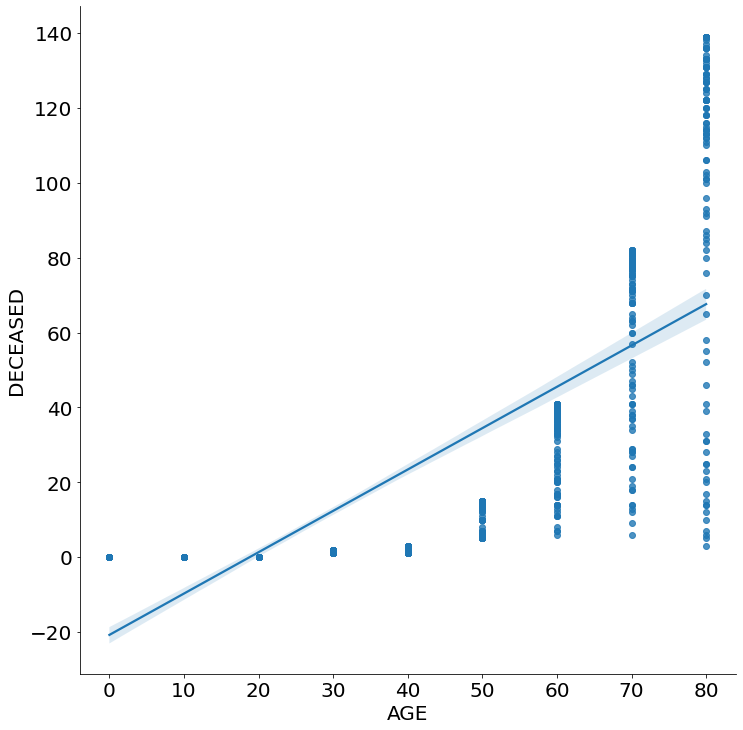

In [ ]:
sns.lmplot(x="age",y='deceased',data=timeage,height = 10)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel("AGE",fontsize = 20)
plt.ylabel("DECEASED",fontsize = 20)
plt.show()

## People's Status by Their Age and Gender
- patientinfo data를 이용한 나이와 성별에 따른 상태 분석

In [ ]:
patientinfo.head()

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow,NaN,75,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,male,30s,Korea,Seoul,Jungnang-gu,overseas inflow,NaN,31,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,male,50s,Korea,Seoul,Jongno-gu,contact with patient,2002000001,17,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,male,20s,Korea,Seoul,Mapo-gu,overseas inflow,NaN,9,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,female,20s,Korea,Seoul,Seongbuk-gu,contact with patient,1000000002,2,NaN,2020-01-31,2020-02-24,NaN,released


In [ ]:
#Finding null rows with respect to age column
patientinfo[patientinfo.age.isnull()]

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
563,1000000564,NaN,NaN,Korea,Seoul,Jungnang-gu,etc,NaN,NaN,NaN,2020-04-06,NaN,NaN,released
564,1000000565,NaN,NaN,Korea,Seoul,Seongdong-gu,overseas inflow,NaN,NaN,NaN,2020-04-06,NaN,NaN,released
565,1000000566,NaN,NaN,Korea,Seoul,Gwanak-gu,overseas inflow,NaN,NaN,NaN,2020-04-06,NaN,NaN,released
566,1000000567,NaN,NaN,Korea,Seoul,Gangnam-gu,overseas inflow,NaN,NaN,NaN,2020-04-06,NaN,NaN,released
567,1000000568,NaN,NaN,Korea,Seoul,Nowon-gu,overseas inflow,NaN,NaN,NaN,2020-04-06,NaN,NaN,released
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5142,6100000130,NaN,NaN,Korea,Gyeongsangnam-do,Hapcheon-gun,overseas inflow,NaN,NaN,NaN,2020-06-15,NaN,NaN,released
5161,7000000016,NaN,NaN,Korea,Jeju-do,Jeju-do,overseas inflow,NaN,NaN,NaN,2020-06-16,2020-06-24,NaN,released
5162,7000000017,NaN,NaN,Bangladesh,Jeju-do,Jeju-do,overseas inflow,NaN,72,NaN,2020-06-18,NaN,NaN,isolated
5163,7000000018,NaN,NaN,Bangladesh,Jeju-do,Jeju-do,overseas inflow,NaN,NaN,NaN,2020-06-18,NaN,NaN,isolated


In [ ]:
#Dropping the null values in the age column
patientinfo.dropna(subset=['age'],inplace=True)
patientinfo.age.isnull().any() # False = There are no null entries in the age column

False

In [ ]:
#The age's in the patientinfo dataframe has 's' in the end, so we have to remove them to make them integer
patientinfo.age = [i.rsplit('s',1)[0] if 's' in i else i for i in patientinfo.age]

In [ ]:
patientinfo.age.value_counts()

20     899
50     667
30     523
40     518
60     482
70     232
10     178
80     170
0       66
90      49
100      1
Name: age, dtype: int64

Text(0, 0.5, 'AGE')

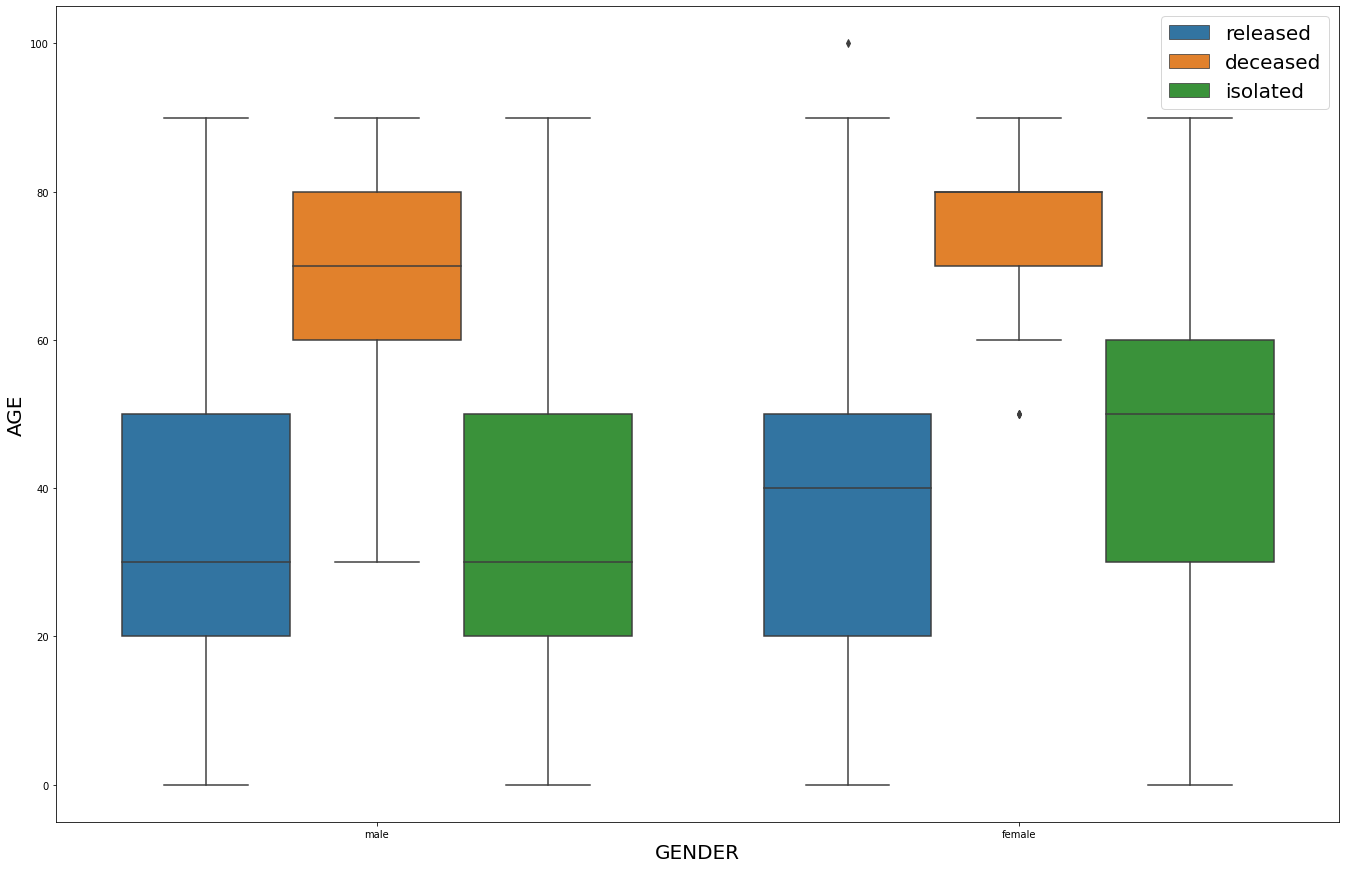

In [ ]:
patientinfo.age = patientinfo.age.astype(int) #making entries integer
f,ax = plt.subplots(figsize = (23,15))
ax = sns.boxplot(x='sex',y="age",hue="state",data=patientinfo)
plt.legend(prop={'size' : 20})
plt.xlabel("GENDER",fontsize = 20)
plt.ylabel("AGE",fontsize = 20)

+ 성별에 따른 차이점을 도출 하기는 어렵지만 사망자(deceased)의 범위는 남자가 넓어 추가 분석이 필요해 보입니다.


# Correlation between patients and variables by age

1. 사용할 컬럼만 추출(사용할 컬럼 : 0, 2, 4, 5, 6, 8)
2. 결측치 처리
3. 데이터 변환
4. 나이별 환자와 변수들관의 상관관계

In [ ]:
train1 = patientinfo

- 사용할 컬럼만 추출(사용할 컬럼 : 0, 2, 4, 5, 6, 8)

In [ ]:
train1_1 = train1.loc[:, ['patient_id','province','city','infected_by','contact_number','age']]

- 결측치 처리
- 데이터 변환

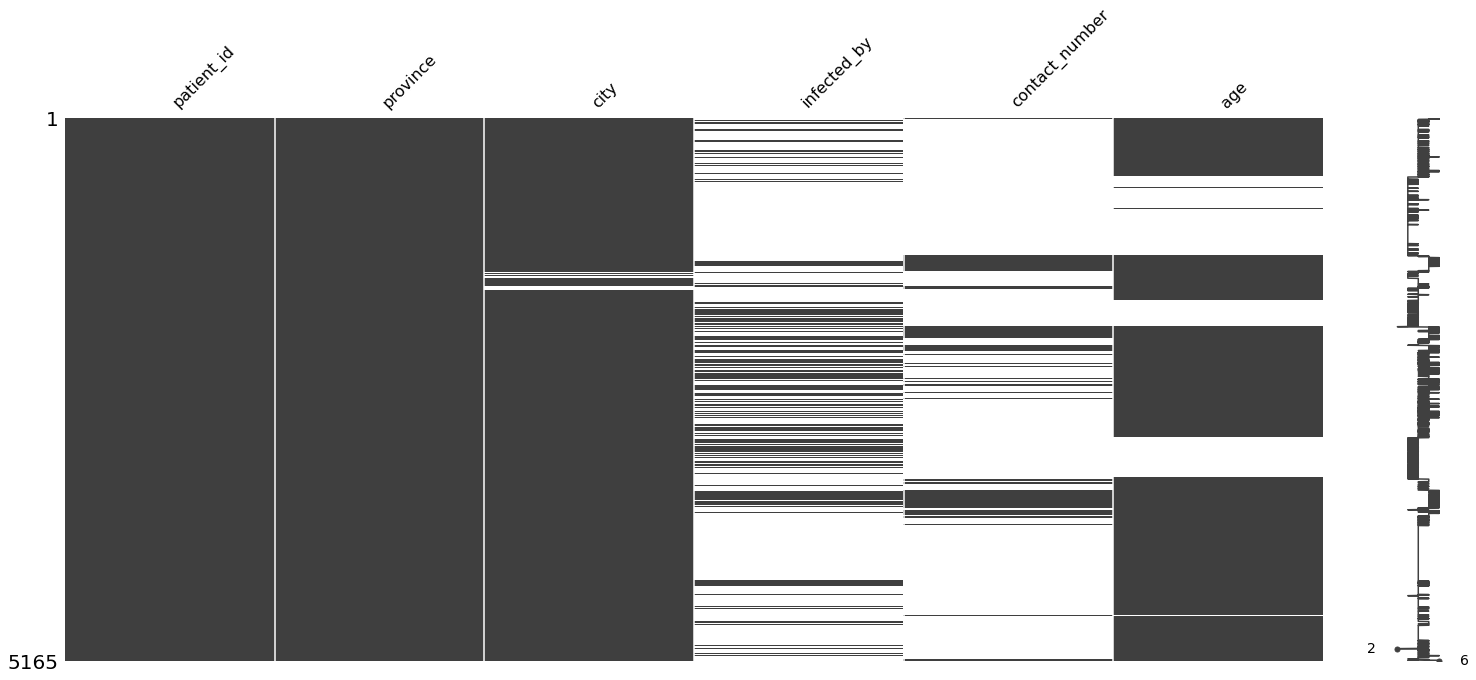

In [ ]:
msno.matrix(train1_1)

In [ ]:
train1_1.isnull()

,patient_id,province,city,infected_by,contact_number,age
0,False,False,False,True,False,False
1,False,False,False,True,False,False
2,False,False,False,False,False,False
3,False,False,False,True,False,False
4,False,False,False,False,False,False
...,...,...,...,...,...,...
5160,False,False,False,True,False,False
5161,False,False,False,True,True,True
5162,False,False,False,True,False,True
5163,False,False,False,True,True,True


In [ ]:
train1_1['age'] = train1_1['age'].str.replace('s', '')

In [ ]:
train1_11 = train1_1.copy()

train1_11['contact_number'] = train1_11['contact_number'].fillna('0')
train1_11['contact_number'] = train1_11['contact_number'].str.replace('-', '0')
train1_11['contact_number'].astype(int)
train1_11['contact_number'] = train1_11['contact_number'].astype(int)

train1_111 = train1_11.drop(3728)

train1_111['infected_by'] = train1_111['infected_by'].fillna('0')
train1_111['infected_by'] = train1_111['infected_by'].str.replace('-', '0')
train1_111['infected_by'].astype(int)
train1_111['infected_by'] = train1_111['infected_by'].astype(int)

In [ ]:
X = train1_111.dropna(axis=0)[['contact_number','infected_by']]
y = train1_111.dropna(axis=0)['age']

lin_reg_model = lin_reg.fit(X, y)

y_pred = lin_reg_model.predict(train1_111.loc[:, ['contact_number', 'infected_by']])
y_pred

array([40.01499447, 40.01499433, 40.55951594, ..., 40.01499446,
       40.01499423, 40.01499423])

In [ ]:
train1_111['age'].fillna(pd.Series(y_pred.flatten()), inplace=True)
train1_1111 = train1_111.drop(5164)

train1_1111

,patient_id,province,city,infected_by,contact_number,age
0,1000000001,Seoul,Gangseo-gu,0,75,50
1,1000000002,Seoul,Jungnang-gu,0,31,30
2,1000000003,Seoul,Jongno-gu,2002000001,17,50
3,1000000004,Seoul,Mapo-gu,0,9,20
4,1000000005,Seoul,Seongbuk-gu,1000000002,2,20
...,...,...,...,...,...,...
5159,7000000014,Jeju-do,Jeju-do,0,140,30
5160,7000000015,Jeju-do,Jeju-do,0,25,30
5161,7000000016,Jeju-do,Jeju-do,0,0,40.014994
5162,7000000017,Jeju-do,Jeju-do,0,72,40.014994


In [ ]:
train1_1111['age'].astype(int)
train1_1111['age'] = train1_1111['age'].astype(int)

In [ ]:
pd.unique(train1_1111['province'])

array(['Seoul', 'Busan', 'Daegu', 'Gwangju', 'Incheon', 'Daejeon',
       'Gyeonggi-do', 'Sejong', 'Ulsan', 'Gangwon-do',
       'Chungcheongbuk-do', 'Chungcheongnam-do', 'Jeollabuk-do',
       'Jeollanam-do', 'Gyeongsangbuk-do', 'Gyeongsangnam-do', 'Jeju-do'],
      dtype=object)

In [ ]:
train1_1111['province'].describe()

count      5163
unique       17
top       Seoul
freq       1312
Name: province, dtype: object

In [ ]:
train1_1111['province'].value_counts()

Seoul                1312
Gyeongsangbuk-do     1254
Gyeonggi-do          1208
Incheon               343
Chungcheongnam-do     168
Busan                 151
Daegu                 137
Gyeongsangnam-do      133
Daejeon               119
Gangwon-do             63
Chungcheongbuk-do      56
Ulsan                  55
Sejong                 51
Gwangju                44
Jeollabuk-do           26
Jeollanam-do           25
Jeju-do                18
Name: province, dtype: int64

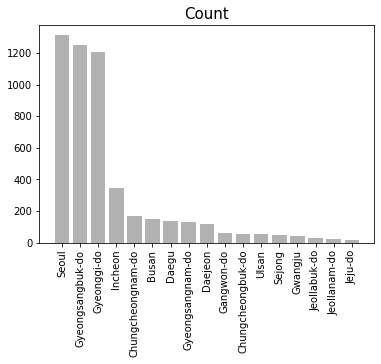

In [ ]:
bar_df = train1_1111["province"].value_counts().reset_index()
plt.title("Count", fontsize=15)
plt.bar(bar_df["index"], bar_df["province"],color='k', alpha=.3)
#plt.ylabel("Province Volume", fontsize=12)
#plt.xlabel("Province", fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [ ]:
train1_1111['province']  = np.where(train1_1111['province'] == 'Seoul', '17', train1_1111['province'])
train1_1111['province']  = np.where(train1_1111['province'] == 'Gyeongsangbuk-do', '16', train1_1111['province'])
train1_1111['province']  = np.where(train1_1111['province'] == 'Gyeonggi-do', '15', train1_1111['province'])
train1_1111['province']  = np.where(train1_1111['province'] == 'Incheon', '14', train1_1111['province'])
train1_1111['province']  = np.where(train1_1111['province'] == 'Chungcheongnam-do', '13', train1_1111['province'])
train1_1111['province']  = np.where(train1_1111['province'] == 'Busan', '12', train1_1111['province'])
train1_1111['province']  = np.where(train1_1111['province'] == 'Daegu', '11', train1_1111['province'])
train1_1111['province']  = np.where(train1_1111['province'] == 'Gyeongsangnam-do', '10', train1_1111['province'])
train1_1111['province']  = np.where(train1_1111['province'] == 'Daejeon', '9', train1_1111['province'])
train1_1111['province']  = np.where(train1_1111['province'] == 'Gangwon-do ', '8', train1_1111['province'])
train1_1111['province']  = np.where(train1_1111['province'] == 'Chungcheongbuk-do', '7', train1_1111['province'])
train1_1111['province']  = np.where(train1_1111['province'] == 'Ulsan', '6', train1_1111['province'])
train1_1111['province']  = np.where(train1_1111['province'] == 'Sejong', '5', train1_1111['province'])
train1_1111['province']  = np.where(train1_1111['province'] == 'Gwangju', '4', train1_1111['province'])
train1_1111['province']  = np.where(train1_1111['province'] == 'Jeollabuk-do', '3', train1_1111['province'])
train1_1111['province']  = np.where(train1_1111['province'] == 'Jeollanam-do', '2', train1_1111['province'])
train1_1111['province']  = np.where(train1_1111['province'] == 'Jeju-do', '1', train1_1111['province'])

In [ ]:
pd.unique(train1_1111['city'])

In [ ]:
train1_1111['city'].describe()

count             5069
unique             163
top       Gyeongsan-si
freq               639
Name: city, dtype: object

In [ ]:
train1_1111['city'].value_counts()

Gyeongsan-si      639
Seongnam-si       173
Bucheon-si        162
Gwanak-gu         113
Cheonan-si        110
                 ... 
sankyeock-dong      1
Gijang-gun          1
Dalseong-gun        1
Hoengseong-gun      1
Yeongwol-gun        1
Name: city, Length: 163, dtype: int64

In [ ]:
train1_1111['city']  = np.where(train1_1111['city'] == 'Gyeongsan-si', '163', train1_1111['city'])
train1_1111['city']  = np.where(train1_1111['city'] == 'Seongnam-si', '51', train1_1111['city'])
train1_1111['city']  = np.where(train1_1111['city'] == 'Bucheon-si', '49', train1_1111['city'])
train1_1111['city']  = np.where(train1_1111['city'] == 'Gwanak-gu', '43', train1_1111['city'])
train1_1111['city']  = np.where(train1_1111['city'] == 'Cheonan-si', '42', train1_1111['city'])
train1_1111['city']  = np.where(train1_1111['city'] == 'sankyeock-dong', '1', train1_1111['city'])
train1_1111['city']  = np.where(train1_1111['city'] == 'Gijang-gun', '1', train1_1111['city'])
train1_1111['city']  = np.where(train1_1111['city'] == 'Dalseong-gun', '1', train1_1111['city'])
train1_1111['city']  = np.where(train1_1111['city'] == 'Yeongwol-gun', '1', train1_1111['city'])

In [ ]:
encoder = LabelEncoder()
train1_1111['city'] = encoder.fit_transform(train1_1111['city'].values)
train1_1111

,patient_id,province,city,infected_by,contact_number,age
0,1000000001,17,42,0,75,50
1,1000000002,17,93,0,31,30
2,1000000003,17,91,2002000001,17,50
3,1000000004,17,95,0,9,20
4,1000000005,17,124,1000000002,2,20
...,...,...,...,...,...,...
5159,7000000014,1,86,0,140,30
5160,7000000015,1,86,0,25,30
5161,7000000016,1,86,0,0,40
5162,7000000017,1,86,0,72,40


- 나이별 환자와 변수들관의 상관관계

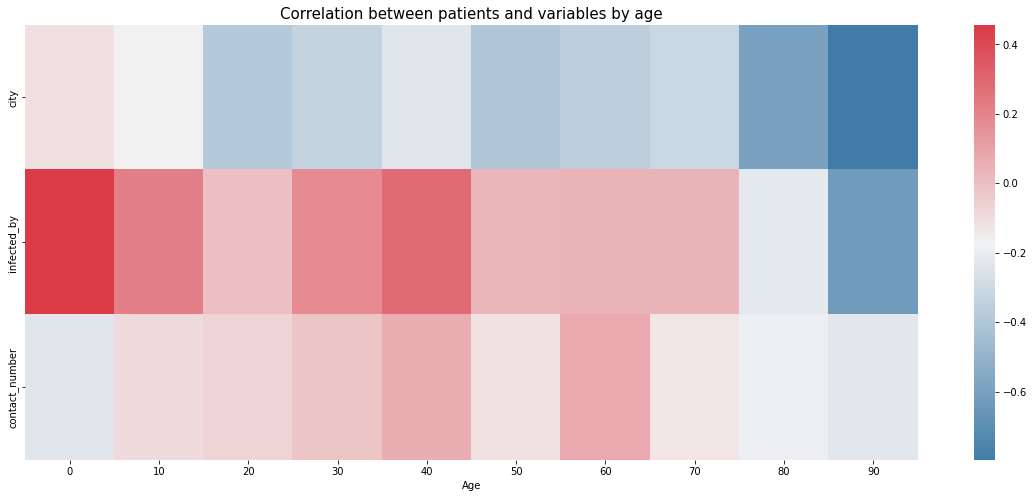

In [ ]:
corr = []
for age in range(0,100,10):
    df = train1_1111[train1_1111.age==age]
    age_corr = df.corr()['patient_id']
    #age_corr = age_corr.drop(['age'])
    age_corr = age_corr.drop(['age','patient_id'])
    #age_corr = patient_id_corr.drop(['patient_id','province','city','infected_by','contact_number'])
    corr.append(age_corr)
corr_df = pd.concat(corr, axis=1).T
corr_df.index = list(range(0,100,10))

# 시각화
f, ax = plt.subplots(figsize=(20,8))
plt.title("Correlation between patients and variables by age", fontsize=15)
sns.heatmap(corr_df.T, cmap=sns.diverging_palette(240,10,as_cmap=True), ax=ax)
plt.xlabel('Age')
plt.show()

In [ ]:
patientinfo.head()

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow,NaN,75,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,male,30s,Korea,Seoul,Jungnang-gu,overseas inflow,NaN,31,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,male,50s,Korea,Seoul,Jongno-gu,contact with patient,2002000001,17,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,male,20s,Korea,Seoul,Mapo-gu,overseas inflow,NaN,9,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,female,20s,Korea,Seoul,Seongbuk-gu,contact with patient,1000000002,2,NaN,2020-01-31,2020-02-24,NaN,released


In [ ]:
patientinfo[patientinfo.age.isnull()]

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
563,1000000564,NaN,NaN,Korea,Seoul,Jungnang-gu,etc,NaN,NaN,NaN,2020-04-06,NaN,NaN,released
564,1000000565,NaN,NaN,Korea,Seoul,Seongdong-gu,overseas inflow,NaN,NaN,NaN,2020-04-06,NaN,NaN,released
565,1000000566,NaN,NaN,Korea,Seoul,Gwanak-gu,overseas inflow,NaN,NaN,NaN,2020-04-06,NaN,NaN,released
566,1000000567,NaN,NaN,Korea,Seoul,Gangnam-gu,overseas inflow,NaN,NaN,NaN,2020-04-06,NaN,NaN,released
567,1000000568,NaN,NaN,Korea,Seoul,Nowon-gu,overseas inflow,NaN,NaN,NaN,2020-04-06,NaN,NaN,released
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5142,6100000130,NaN,NaN,Korea,Gyeongsangnam-do,Hapcheon-gun,overseas inflow,NaN,NaN,NaN,2020-06-15,NaN,NaN,released
5161,7000000016,NaN,NaN,Korea,Jeju-do,Jeju-do,overseas inflow,NaN,NaN,NaN,2020-06-16,2020-06-24,NaN,released
5162,7000000017,NaN,NaN,Bangladesh,Jeju-do,Jeju-do,overseas inflow,NaN,72,NaN,2020-06-18,NaN,NaN,isolated
5163,7000000018,NaN,NaN,Bangladesh,Jeju-do,Jeju-do,overseas inflow,NaN,NaN,NaN,2020-06-18,NaN,NaN,isolated


In [ ]:
patientinfo.dropna(subset=['age'],inplace=True)
patientinfo.age.isnull().any() # False = There are no null entries in the age column

False

In [ ]:
patientinfo.age = [i.rsplit('s',1)[0] if 's' in i else i for i in patientinfo.age]
patientinfo.age = patientinfo.age.astype(int)

In [ ]:
patientinfo.head()

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,male,50,Korea,Seoul,Gangseo-gu,overseas inflow,NaN,75,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,male,30,Korea,Seoul,Jungnang-gu,overseas inflow,NaN,31,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,male,50,Korea,Seoul,Jongno-gu,contact with patient,2002000001,17,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,male,20,Korea,Seoul,Mapo-gu,overseas inflow,NaN,9,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,female,20,Korea,Seoul,Seongbuk-gu,contact with patient,1000000002,2,NaN,2020-01-31,2020-02-24,NaN,released


In [ ]:
patientinfo.age.value_counts()

20     899
50     667
30     523
40     518
60     482
70     232
10     178
80     170
0       66
90      49
100      1
Name: age, dtype: int64

In [ ]:
sort_age = patientinfo.age.value_counts()


sort_age=sort_age.sort_index()
print(sort_age.index)

Int64Index([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], dtype='int64')


In [ ]:
province = patientinfo.province.value_counts()

print(province)

Gyeongsangbuk-do     1246
Gyeonggi-do           830
Seoul                 584
Chungcheongnam-do     168
Busan                 149
Daegu                 137
Gyeongsangnam-do      129
Daejeon               119
Incheon                92
Gangwon-do             61
Chungcheongbuk-do      56
Ulsan                  53
Sejong                 51
Gwangju                44
Jeollabuk-do           26
Jeollanam-do           25
Jeju-do                15
Name: province, dtype: int64


In [ ]:
df_age1020 = patientinfo[patientinfo['age'].isin([10,20])]
df_age1020

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
3,1000000004,male,20,Korea,Seoul,Mapo-gu,overseas inflow,NaN,9,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,female,20,Korea,Seoul,Seongbuk-gu,contact with patient,1000000002,2,NaN,2020-01-31,2020-02-24,NaN,released
6,1000000007,male,20,Korea,Seoul,Jongno-gu,contact with patient,1000000003,0,NaN,2020-01-31,2020-02-10,NaN,released
7,1000000008,male,20,Korea,Seoul,etc,overseas inflow,NaN,0,NaN,2020-02-02,2020-02-24,NaN,released
11,1000000012,male,20,Korea,Seoul,etc,overseas inflow,NaN,0,NaN,2020-02-07,2020-02-27,NaN,released
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5153,7000000008,female,10,Korea,Jeju-do,Jeju-do,overseas inflow,NaN,25,NaN,2020-03-27,2020-04-12,NaN,released
5154,7000000009,female,20,Korea,Jeju-do,Jeju-do,overseas inflow,NaN,14,NaN,2020-03-29,2020-04-28,NaN,released
5155,7000000010,female,20,Korea,Jeju-do,Jeju-do,overseas inflow,NaN,18,NaN,2020-04-03,2020-04-21,NaN,released
5157,7000000012,female,20,Korea,Jeju-do,Jeju-do,overseas inflow,NaN,9,NaN,2020-04-03,2020-05-05,NaN,released


In [ ]:
df_age_over_60 = patientinfo[patientinfo['age'].isin([60,70,80,90,100])]
df_age_over_60

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
9,1000000010,female,60,Korea,Seoul,Seongbuk-gu,contact with patient,1000000003,6,NaN,2020-02-05,2020-02-29,NaN,released
12,1000000013,male,80,Korea,Seoul,Jongno-gu,contact with patient,1000000017,117,NaN,2020-02-16,NaN,NaN,deceased
13,1000000014,female,60,Korea,Seoul,Jongno-gu,contact with patient,1000000013,27,2020-02-06,2020-02-16,2020-03-12,NaN,released
14,1000000015,male,70,Korea,Seoul,Seongdong-gu,Seongdong-gu APT,NaN,8,2020-02-11,2020-02-19,NaN,NaN,released
15,1000000016,male,70,Korea,Seoul,Jongno-gu,contact with patient,1000000017,NaN,NaN,2020-02-19,2020-03-11,NaN,released
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5112,6100000100,female,60,Korea,Gyeongsangnam-do,Jinju-si,etc,6100000097,NaN,2020-03-28,2020-03-31,NaN,NaN,released
5116,6100000104,female,70,Korea,Gyeongsangnam-do,Sancheong-gun,etc,6100000097,NaN,2020-03-26,2020-03-31,NaN,NaN,released
5124,6100000112,male,60,Korea,Gyeongsangnam-do,Hapcheon-gun,contact with patient,6100000100,NaN,2020-04-03,2020-04-07,NaN,NaN,released
5128,6100000116,male,60,Korea,Gyeongsangnam-do,Changwon-si,etc,NaN,NaN,2020-04-20,2020-04-21,2020-05-15,NaN,released


In [ ]:
df_age1020_count = df_age1020.province.value_counts()
df_age1020_count

Gyeongsangbuk-do     366
Gyeonggi-do          217
Seoul                192
Busan                 63
Gyeongsangnam-do      37
Daegu                 32
Chungcheongnam-do     31
Daejeon               27
Ulsan                 22
Incheon               17
Gwangju               14
Gangwon-do            14
Chungcheongbuk-do     13
Jeollabuk-do          11
Jeju-do                9
Jeollanam-do           8
Sejong                 4
Name: province, dtype: int64

In [ ]:
df_age_over_60_count = df_age_over_60.province.value_counts()
df_age_over_60_count

Gyeongsangbuk-do     411
Gyeonggi-do          180
Seoul                 85
Daegu                 45
Daejeon               43
Busan                 30
Gyeongsangnam-do      30
Chungcheongnam-do     28
Incheon               18
Gangwon-do            18
Gwangju               13
Chungcheongbuk-do     12
Jeollabuk-do           7
Jeollanam-do           7
Ulsan                  6
Sejong                 1
Name: province, dtype: int64

In [ ]:
age_over1020_infection_case = df_age1020.infection_case.value_counts()
age_over1020_infection_case

overseas inflow                    306
contact with patient               245
etc                                144
Shincheonji Church                  44
Onchun Church                       21
Guro-gu Call Center                 15
Itaewon Clubs                       13
Dongan Church                        9
Coupang Logistics Center             5
Seongdong-gu APT                     4
Milal Shelter                        3
Changnyeong Coin Karaoke             3
Eunpyeong St. Mary's Hospital        2
gym facility in Sejong               1
gym facility in Cheonan              1
River of Grace Community Church      1
Cheongdo Daenam Hospital             1
Name: infection_case, dtype: int64

In [ ]:
patientinfo.infection_case.value_counts()

contact with patient                     1112
overseas inflow                           653
etc                                       638
Guro-gu Call Center                       112
Shincheonji Church                        103
Onchun Church                              33
Bonghwa Pureun Nursing Home                31
gym facility in Cheonan                    30
Ministry of Oceans and Fisheries           28
Itaewon Clubs                              26
Coupang Logistics Center                   24
Cheongdo Daenam Hospital                   21
Dongan Church                              17
Eunpyeong St. Mary's Hospital              16
Gyeongsan Seorin Nursing Home              15
Seongdong-gu APT                           13
Dunsan Electronics Town                    13
Gyeongsan Jeil Silver Town                 12
Milal Shelter                              11
Gyeongsan Cham Joeun Community Center      10
Orange Town                                 7
Geochang Church                   

## 연령대 별 확진자 그래프(아래)

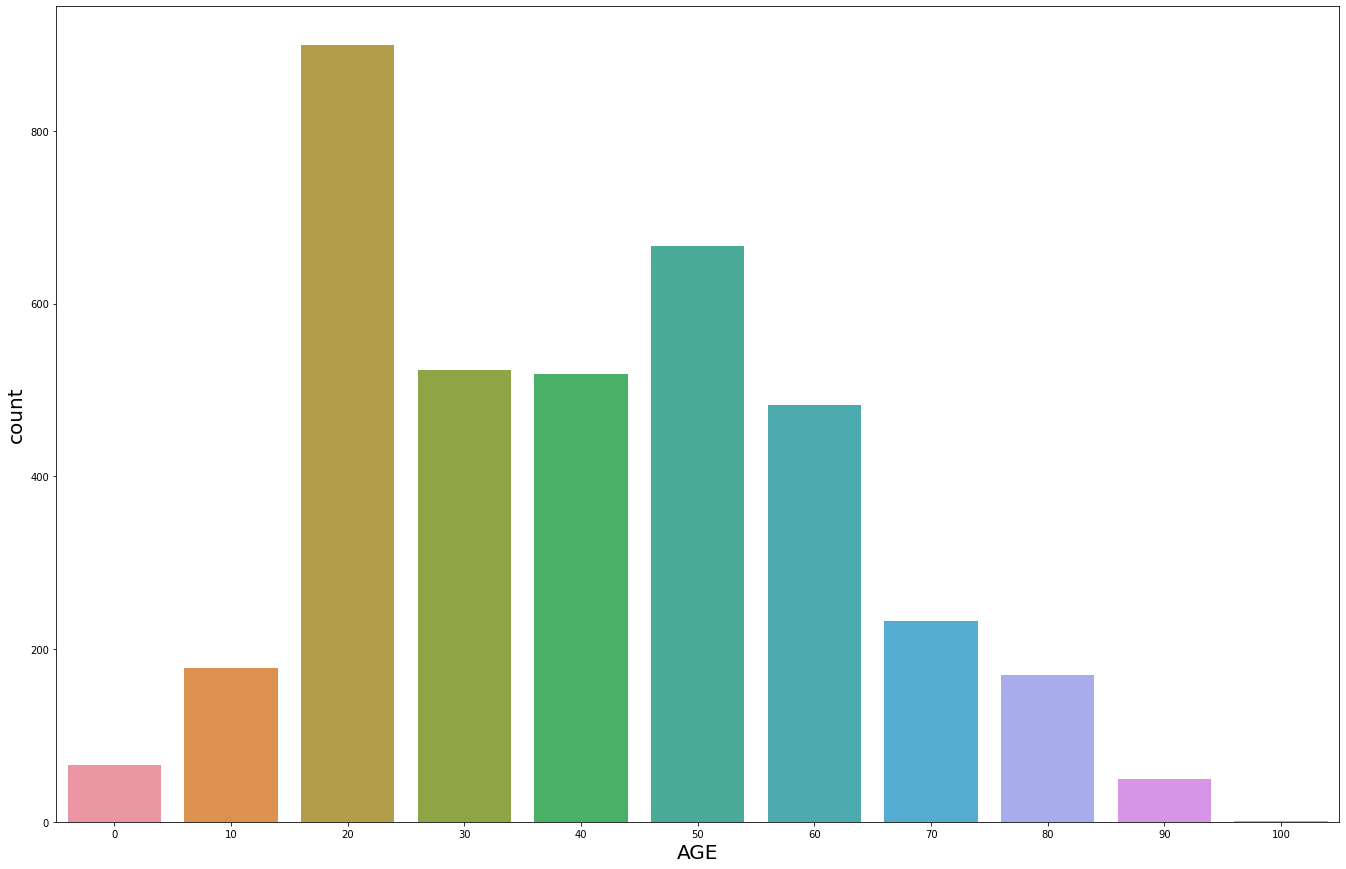

0       66
10     178
20     899
30     523
40     518
50     667
60     482
70     232
80     170
90      49
100      1
Name: age, dtype: int64


In [ ]:
f,ax = plt.subplots(figsize = (23,15))
ax = sns.barplot(x=sort_age.index, y= sort_age.values,data=patientinfo)
plt.xlabel("AGE",fontsize = 20)
plt.ylabel("count",fontsize = 20)
plt.show()
print(sort_age)

## 전체 확진자와 1020, 60대이상 확진자의 거주지역 비교 그래프(아래)

In [ ]:
fig=go.Figure()
fig.add_trace((go.Bar(x=province.index, y=province.values,
                    name="total")))
fig.add_trace((go.Bar(x=province.index, y=df_age1020_count.values,
                    name="1020")))
fig.add_trace((go.Bar(x=province.index, y=df_age_over_60_count.values,
                    name="OVER60")))
fig.update_layout(xaxis_title="PROVINCE",
                   yaxis_title="COUNT",
                   template="seaborn")
fig.show(renderer="colab")

![total,1020,60+](https://user-images.githubusercontent.com/96756158/157607738-ce241113-d578-4875-9da3-3f1703349c03.png)


## 10대 20대와 60대 이상 확진자의 거주지역 비교 그래프(아래)

In [ ]:
fig=go.Figure()
fig.add_trace((go.Bar(x=df_age1020_count.index, y=df_age1020_count.values,
                    name="1020")))
fig.add_trace((go.Bar(x=df_age1020_count.index, y=df_age_over_60_count.values,
                    name="OVER60")))
fig.update_layout(xaxis_title="PROVINCE",
                   yaxis_title="COUNT",
                   template="seaborn")
fig.show(renderer="colab")

![1020,60+](https://user-images.githubusercontent.com/96756158/157607644-fa4597c7-ed1c-47b1-8efb-e65a85f278f3.png)

 - 대부분의 경우 1020의 감염자 수와 노령층의 감염자수가 비슷하게 나타나는 경향을 보이지만 유독 서울만 1020의 감염자 수가 노령층의 감염자 수에 비해 높은 것을 볼 수 있고, 경상북도의 경우 노령층의 감염자 수가 1020에 비해 유의미하게 많은 것을 확인 할 수 있다.



##10,20대와 60대 이상 확진자의 감염케이스 비교 그래프.(아래)

In [ ]:
fig=go.Figure()

fig.add_trace((go.Bar(x=df_age_over_60["infection_case"].value_counts().index, y=df_age1020["infection_case"].value_counts(),
                    name="1020")))
fig.add_trace((go.Bar(x=df_age_over_60["infection_case"].value_counts().index, y=df_age_over_60["infection_case"].value_counts(),
                    name="OVER60")))
fig.update_layout(title="Accumulated test results over time",
                   xaxis_title="INFECTION_CASE",
                   yaxis_title="COUNT",
                   template="seaborn")
fig.show(renderer="colab")

![infection_case](https://user-images.githubusercontent.com/96756158/157607844-f8de75da-bd5f-41cf-bcdf-db94cabbb9ec.png)

확진자의 감염케이스를 1020과 노령인구를 비교해본 그래프이다. 가장 신기했던 점은 아무래도 이태원클럽의 감염케이스에 노인인구가 있는 것인데 아마도 클럽을 다녀온 20대와 접촉하여 감염된 사례가 아닌가 하는 생각이 들고, 요양원의 20대 감염자는 요양원에서 종사하는 10-20대나 요양원을 방문한 10-20대가 감염된 사례가 아닐까 하는 생각을 한다.

## region & case 분석
- region 데이터의 academy_ratio 가 높은 경우 인구 밀집도가 높을 것이다.(대도시에 교육이 많기 때문이라고 생각함)
- 인구 밀집도가 높은 곳에서 코로나 확진자가 높을 것이라고 생각합니다.
- case 데이터의 경우와 비교하여 대확진이 발생한 곳은 대도시라고 예상한 결과를 확인해본다.

In [ ]:
region


,code,province,city,latitude,longitude,elementary_school_count,kindergarten_count,university_count,academy_ratio,elderly_population_ratio,elderly_alone_ratio,nursing_home_count
0,10000,Seoul,Seoul,37.566953,126.977977,607,830,48,1.44,15.38,5.8,22739
1,10010,Seoul,Gangnam-gu,37.518421,127.047222,33,38,0,4.18,13.17,4.3,3088
2,10020,Seoul,Gangdong-gu,37.530492,127.123837,27,32,0,1.54,14.55,5.4,1023
3,10030,Seoul,Gangbuk-gu,37.639938,127.025508,14,21,0,0.67,19.49,8.5,628
4,10040,Seoul,Gangseo-gu,37.551166,126.849506,36,56,1,1.17,14.39,5.7,1080
...,...,...,...,...,...,...,...,...,...,...,...,...
239,61160,Gyeongsangnam-do,Haman-gun,35.272481,128.406540,16,20,0,1.19,23.74,14.7,94
240,61170,Gyeongsangnam-do,Hamyang-gun,35.520541,127.725177,13,12,0,1.01,32.65,20.9,83
241,61180,Gyeongsangnam-do,Hapcheon-gun,35.566702,128.165870,17,15,0,0.71,38.44,24.7,96
242,70000,Jeju-do,Jeju-do,33.488936,126.500423,113,123,4,1.53,15.10,6.4,1245


In [ ]:
region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   code                      244 non-null    int64  
 1   province                  244 non-null    object 
 2   city                      244 non-null    object 
 3   latitude                  244 non-null    float64
 4   longitude                 244 non-null    float64
 5   elementary_school_count   244 non-null    int64  
 6   kindergarten_count        244 non-null    int64  
 7   university_count          244 non-null    int64  
 8   academy_ratio             244 non-null    float64
 9   elderly_population_ratio  244 non-null    float64
 10  elderly_alone_ratio       244 non-null    float64
 11  nursing_home_count        244 non-null    int64  
dtypes: float64(5), int64(5), object(2)
memory usage: 23.0+ KB


In [ ]:
case

,case_id,province,city,group,infection_case,confirmed,latitude,longitude
0,1000001,Seoul,Yongsan-gu,True,Itaewon Clubs,139,37.538621,126.992652
1,1000002,Seoul,Gwanak-gu,True,Richway,119,37.48208,126.901384
2,1000003,Seoul,Guro-gu,True,Guro-gu Call Center,95,37.508163,126.884387
3,1000004,Seoul,Yangcheon-gu,True,Yangcheon Table Tennis Club,43,37.546061,126.874209
4,1000005,Seoul,Dobong-gu,True,Day Care Center,43,37.679422,127.044374
...,...,...,...,...,...,...,...,...
169,6100012,Gyeongsangnam-do,-,False,etc,20,-,-
170,7000001,Jeju-do,-,False,overseas inflow,14,-,-
171,7000002,Jeju-do,-,False,contact with patient,0,-,-
172,7000003,Jeju-do,-,False,etc,4,-,-


In [ ]:
case.confirmed

0      139
1      119
2       95
3       43
4       43
      ... 
169     20
170     14
171      0
172      4
173      1
Name: confirmed, Length: 174, dtype: int64

In [ ]:
 import plotly

In [ ]:
fig = go.Figure(data=go.Scattergeo(
    lon =region.longitude,
    lat = region.latitude,
    text = region.city,
    mode = 'markers',
    marker= dict(
        size=region.academy_ratio*10,
        line = dict(width=1,color = "white"),
        opacity=.8,
        color = 'red'
    )
))

fig.update_layout(title="academy ratio Locations",hovermode='closest')               

plotly.offline.plot(fig)

'temp-plot.html'

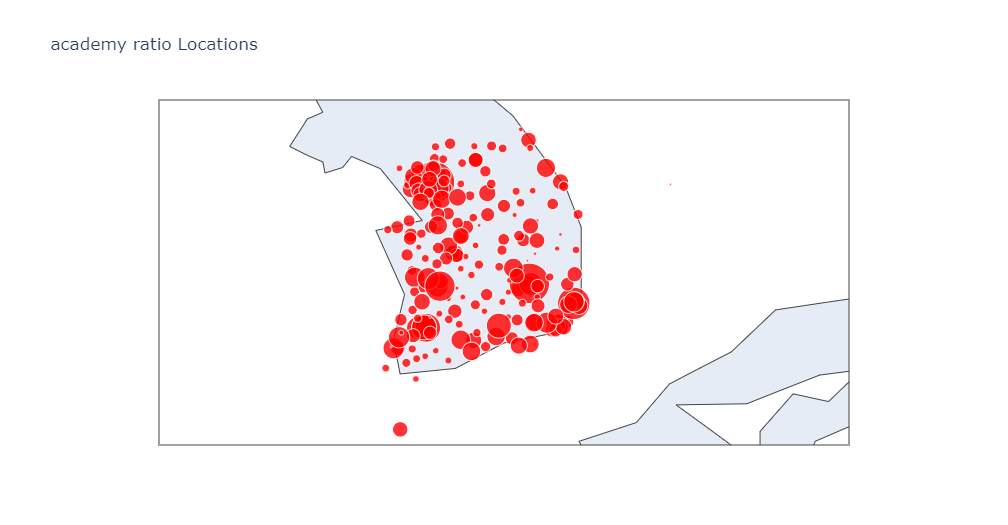

+ 대도시와 수도권지역이 학업인구 비중이 높습니다.


In [ ]:
fig = go.Figure(data=go.Scattergeo(
    lon =case.longitude,
    lat = case.latitude,
    text = case.city,
    mode = 'markers',
    marker= dict(
        size=8,
        line = dict(width=1,color = "white"),
        opacity=.8,
        color = 'blue'
    )
))

fig.update_layout(title="Patients Locations",hovermode='closest')               

fig.show(renderer="colab")

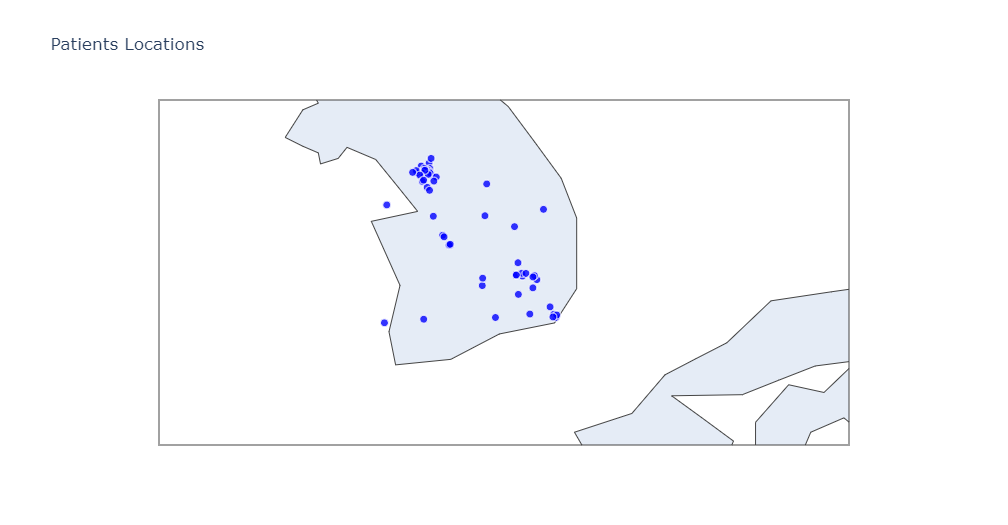

- 대규모 감염의 경우를 나타낸 지도입니다.

In [ ]:
fig = go.Figure(data=go.Scattergeo(
    lon =case.longitude,
    lat = case.latitude,
    text = case.confirmed,
    mode = 'markers',
    marker= dict(
        size=case.confirmed*0.1,
        line = dict(width=1,color = "white"),
        opacity=.5,
        color = 'blue'
    )
))

fig.update_layout(title="Patients Locations",hovermode='closest')               

fig.show(renderer="colab")

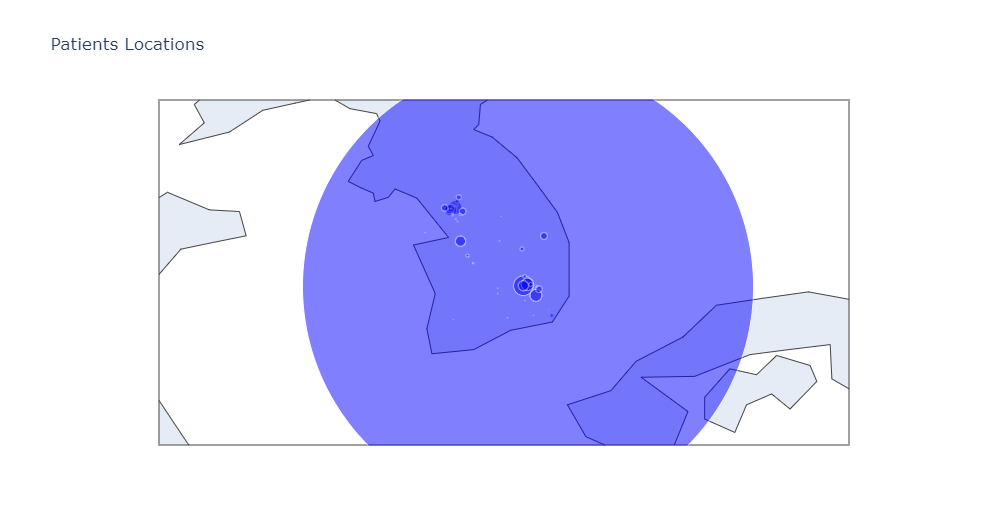

+ 2020년 초 대구경북 지역의 신천지 확진자수가 다른 값 보다 너무 커서 원의 크기가 큽니다.

In [ ]:
fig = go.Figure(data=go.Scattergeo(
    lon =region.longitude,
    lat = region.latitude,
    text = region.city,
    mode = 'markers',
    name = "City location",
    marker= dict(
        size=region.academy_ratio*10,
        line = dict(width=1,color = "white"),
        opacity=.8,
        color = 'red'
    )
))

fig.add_trace(go.Scattergeo(
    lon =case.longitude,
    lat = case.latitude,
    text = case.city,
    mode = 'markers',
    name = "Patients",
    marker= dict(
        size=8,
        line = dict(width=1,color = "white"),
        opacity=.8,
        color = 'blue'
    )
))


fig.update_layout(title="combined",hovermode='closest')               

fig.show(renderer="colab")

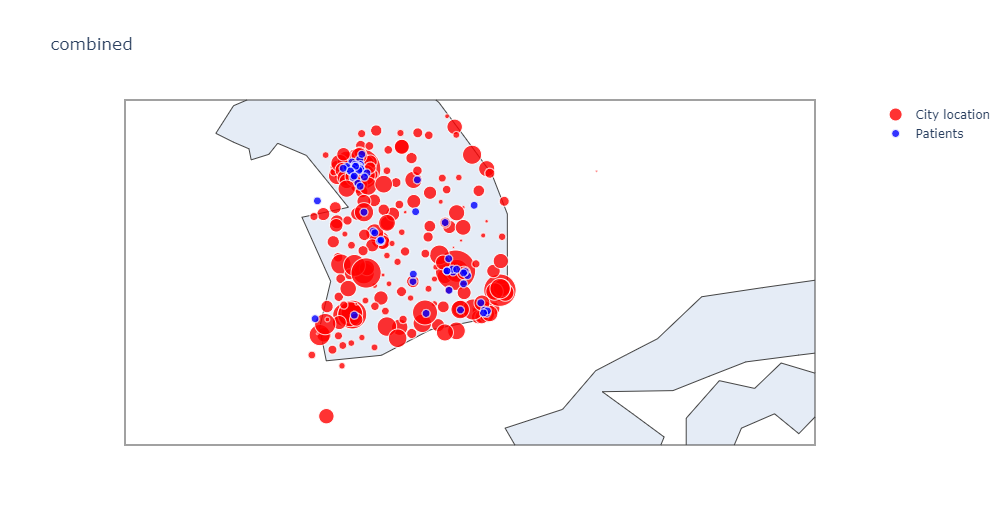

+ 대도시와 수도권에서의 인구 밀집도가 높기 때문에 대규모 전파의 경우 위치가 동일 함을 확인 할 수 있습니다.
+ 사회적 거리두기를 통해 접촉을 막는 정책이 필요하다고 판단 할 수 있습니다.